# Data Understanding

Importing the used modules

In [8]:

import pandas as pd

import glob
import os

import cv2
import numpy as np
import torch

from tqdm import tqdm

torch.backends.cudnn.benchmark = True

from timm.data import ImageDataset, create_loader

import matplotlib.pyplot as plt

%matplotlib inline

Here we create some helper variables and display the train.csv file to check the format.

In [9]:
BASE_DIRECTORY = '../dfl-bundesliga-data-shootout/'
EXTENTSION = '.mp4'
CLIPS_PATH = BASE_DIRECTORY + 'clips'
TRAIN_PATH = BASE_DIRECTORY + 'train'
TEST_PATH = BASE_DIRECTORY + 'test'

train_csv = pd.read_csv(BASE_DIRECTORY + 'train.csv')
print(train_csv.shape)
train_csv.head()

(11218, 4)


,video_id,time,event,event_attributes
0,1606b0e6_0,200.265822,start,NaN
1,1606b0e6_0,201.150000,challenge,['ball_action_forced']
2,1606b0e6_0,202.765822,end,NaN
3,1606b0e6_0,210.124111,start,NaN
4,1606b0e6_0,210.870000,challenge,['opponent_dispossessed']


Let's load the videos.

In [20]:
def get_video_length(video_path: str) -> int:
    video = cv2.VideoCapture(video_path)
    frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)
    return frame_count

def extract_images(video_path, out_dir):
    IMG_SIZE = (1920, 1080)
    # get video name from the path to the video
    video_name = os.path.basename(video_path).split('.')[0]
    cam = cv2.VideoCapture(video_path)

    # start counting frames
    frame_count = 1
    while True:
        # check if the next frame is readable and try to read it
        successed, img = cam.read()
        if not successed:
            break
        # create the name of the output file, also put the frame count in the name
        outfile = f'{out_dir}/{video_name}-{frame_count:06}.jpg'
        # resize the output photo
        img = cv2.resize(img, dsize=IMG_SIZE)
        # write the resized frame to the output directory
        cv2.imwrite(outfile, img)
        frame_count += 1 

video_ids = train_csv['video_id'].values
videos_durations = {video_id: get_video_length(BASE_DIRECTORY + 'train/' + video_id + EXTENTSION) for video_id in video_ids}
print(videos_durations)

{'1606b0e6_0': 85915.0, '1606b0e6_1': 85138.0, '35bd9041_0': 88653.0, '35bd9041_1': 87732.0, '3c993bd2_0': 89750.0, '3c993bd2_1': 88760.0, '407c5a9e_1': 87058.0, '4ffd5986_0': 87620.0, '9a97dae4_1': 83513.0, 'cfbe2e94_0': 90500.0, 'cfbe2e94_1': 89925.0, 'ecf251d4_0': 85500.0}


Now we turn the videos into images.

In [ ]:
for id in video_ids:
    extract_images(BASE_DIRECTORY + 'train/' + id + EXTENTSION, BASE_DIRECTORY + 'images/' + id + '/')

Let's plot the number of frames in each video.

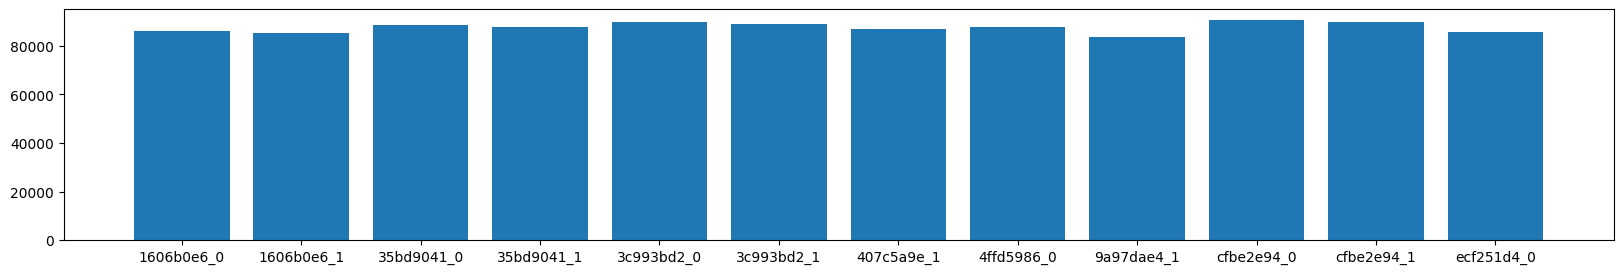

In [23]:
plt.figure(figsize=(20, 3))
plt.bar(range(len(videos_durations)), list(videos_durations.values()), align='center')
plt.xticks(range(len(videos_durations)), list(videos_durations.keys()))
plt.show()

After that let's count the number of missing values in each attribute in the csv file.

In [11]:
train_csv.isna().sum()

video_id               0
time                   0
event                  0
event_attributes    6836
dtype: int64

In [12]:
start_end_events = train_csv[train_csv['event'].isin(['start', 'end'])]
print(start_end_events.shape)
start_end_events.isna().sum()

(6836, 4)


video_id               0
time                   0
event                  0
event_attributes    6836
dtype: int64

We can see here that the training data is relatively clean. The only column which contains null values is the `event_attributes`. Moreover, the null values only occus when the associated event is `start` or `end`. 

Let's check the number of events for each video.

['1606b0e6_0' '1606b0e6_1' '35bd9041_0' '35bd9041_1' '3c993bd2_0'
 '3c993bd2_1' '407c5a9e_1' '4ffd5986_0' '9a97dae4_1' 'cfbe2e94_0'
 'cfbe2e94_1' 'ecf251d4_0']
[1000 1249 1075  933 1042  966  858  792  737  823  763  980]
Total number of videos is 12


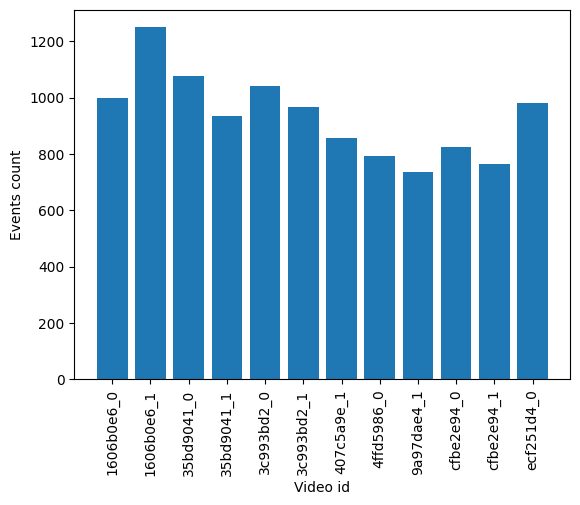

In [13]:
unique, counts = np.unique(train_csv['video_id'].values, return_counts=True)
print(unique)
print(counts)
print(f"Total number of videos is {len(counts)}")
poses = range(len(unique))
plt.bar(unique, counts, width=.8,)
plt.xticks(poses, unique, rotation=90)
plt.xlabel("Video id")
plt.ylabel("Events count")
plt.show()

Next let's analyze the number of rows for each type of event.

['challenge' 'end' 'play' 'start' 'throwin']
[ 624 3418 3586 3418  172]
Total number of event types is 5


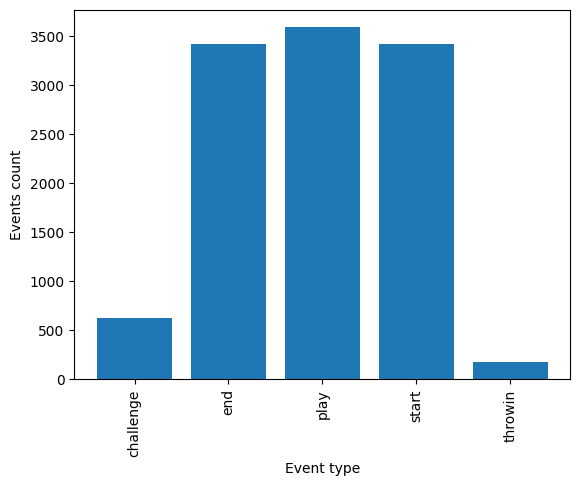

In [14]:
unique, counts = np.unique(train_csv['event'].values, return_counts=True)
print(unique)
print(counts)
print(f"Total number of event types is {len(counts)}")
poses = range(len(unique))
plt.bar(unique, counts, width=.8,)
plt.xticks(poses, unique, rotation=90)
plt.xlabel("Event type")
plt.ylabel("Events count")
plt.show()

Here we are going to count the number of events that occur in each video in segments of 20 seconds.

First, let's get the maximum time in all of the videos then divide it by 20 to get the number of segments where we will count the events.

In [15]:
unique, counts = np.unique(train_csv['time'].values, return_counts=True)
mx_time = np.max(unique)
print(mx_time)
segment = 20
iterations = int(np.ceil(mx_time / segment))

3575.0007270923616


Text(0, 0.5, 'events count')

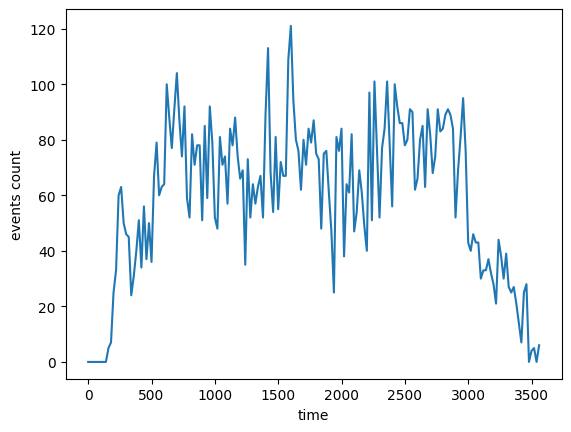

In [16]:
ranges = [(i * segment, (i + 1) * segment - 1) for i in range(iterations)]
times = [i * segment for i in range(iterations)]
counts = []
for l, r in ranges:
    # get all the events between l and r as a list then get the length of that list
    cur_current = train_csv[(train_csv['time'] >= l) & (train_csv['time'] <= r)].shape[0]
    # that length will be the count of events that happens for the range [l, r]
    counts.append(cur_current)

plt.plot(times, counts)
plt.xlabel("time")
plt.ylabel("events count")

Now let's look at the number of events that happen at the same time.

796


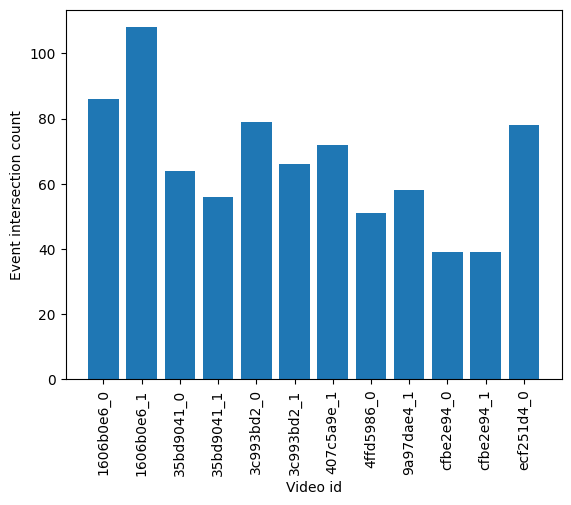

In [17]:
unique = np.unique(train_csv['video_id'].values, return_counts=False)
count = {}
for i in unique:
    count[i] = 0

# count the number of times more than one event is present between a "start" and "end" in each video
current_events = 0
for index, row in train_csv.iterrows():
    if row['event'] == 'start':
        current_events = 0
        continue
    if row['event'] == 'end':
        current_events = 0
        continue
    current_events += 1
    if current_events == 2:
        count[row['video_id']] += 1

counts = []
for i in unique:
    counts.append(count[i])
poses = range(len(unique))

print(sum(counts))
plt.bar(unique, counts, width=.8,)
plt.xticks(poses, unique, rotation=90)
plt.xlabel("Video id")
plt.ylabel("Event intersection count")
plt.show()   

Let's ​analyze these intersections further and see which types are most likely to intersect.

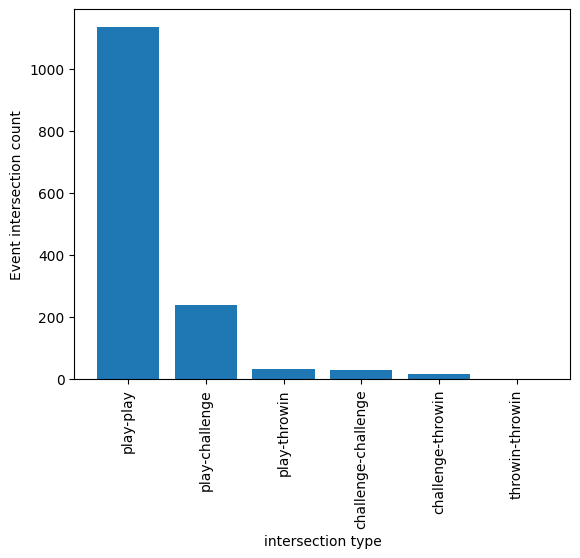

In [18]:
count = {}
count['play-play'] = 0
count['play-challenge'] = 0
count['play-throwin'] = 0
count['challenge-challenge'] = 0
count['challenge-throwin'] = 0
count['throwin-throwin'] = 0

current_events = []
for index, row in train_csv.iterrows():
    if row['event'] == 'start':
        current_events.clear()
        continue
    if row['event'] == 'end':
        current_events.clear()
        continue
    current_events.append(row['event'])
    # if we reach here that means a new event appeared between a "start" and "end"
    # check all the other events currently happening and keep count for each combination
    for i in range(len(current_events)):
        for j in range(i + 1, len(current_events)):
            if current_events[i] == "play" and current_events[j] == "play":
                count['play-play'] += 1
            if current_events[i] == "challenge" and current_events[j] == "play":
                count['play-challenge'] += 1
            if current_events[i] == "play" and current_events[j] == "challenge":
                count['play-challenge'] += 1
            if current_events[i] == "play" and current_events[j] == "throwin":
                count['play-throwin'] += 1
            if current_events[i] == "throwin" and current_events[j] == "play":
                count['play-throwin'] += 1
            if current_events[i] == "challenge" and current_events[j] == "challenge":
                count['challenge-challenge'] += 1
            if current_events[i] == "challenge" and current_events[j] == "throwin":
                count['challenge-throwin'] += 1
            if current_events[i] == "throwin" and current_events[j] == "challenge":
                count['challenge-throwin'] += 1
            if current_events[i] == "throwin" and current_events[j] == "throwin":
                count['throwin-throwin'] += 1
    

poses = range(len(count.keys()))
counts = []
for i in list(count.items()):
    counts.append(i[1])

plt.bar(list(count.keys()), counts, width=.8,)
plt.xticks(poses, list(count.keys()), rotation=90)
plt.xlabel("intersection type")
plt.ylabel("Event intersection count")
plt.show()   